# Dataset Processing — Step 2: Generate Structured Dataset

**Goal:**  
This notebook converts raw `.svs` / `.tif` + `.xml` data into a clean, versioned, and patch-based dataset.  
Outputs are organized under `ProcessedDataset/v1_40x_area20/` and include:
- `whole_slide/` → full-resolution type and instance maps  
- `patches_p128/` → cropped 128×128 image/label pairs  
- `_meta/` → class map + parameters  
- `logs/` → run summaries  

---

### Steps
1. Configure paths and parameters  
2. Create folder structure  
3. Discover `.svs` / `.xml` pairs  
4. Parse polygons → generate `inst_map` & `type_map`  
5. Extract and save 128×128 patches    

---

### Table of Contents
- [Step 1 — Setup and Folder Creation](#step1)
- [Step 2 — Pair .svs/.xml Files](#step2)
- [Step 3 — XML Parsing Functions](#step3)
- [Step 4 — Patch Generation](#step4)


<a id="step1"></a>
## Step 1 — Setup and Folder Creation


In [1]:
from pathlib import Path
import json, os
from datetime import datetime
from xml.dom import minidom

# === Configuration ===
PATCH_SIZE = 128
MIN_POLY_AREA = 20

RAW_ROOT = Path(
    "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/"
    "AI-guided-whole-slide-imaging-analysis/Datasets/BU_course_data/"
    "TrainingData/TrainingImages_and_Annotations"
)

OUT_ROOT = Path(
    f"/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area{MIN_POLY_AREA}_2"
)

# === Create folder structure ===
dirs = [
    OUT_ROOT / "whole_slide" / "type_maps",
    OUT_ROOT / "whole_slide" / "inst_maps",
    OUT_ROOT / "whole_slide" / "debug",
    OUT_ROOT / f"patches_p{PATCH_SIZE}" / "images",
    OUT_ROOT / f"patches_p{PATCH_SIZE}" / "labels",
    OUT_ROOT / f"patches_p{PATCH_SIZE}" / "debug",
    OUT_ROOT / "_meta",
    OUT_ROOT / "logs",
]
for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

print(f"✅ Folder structure initialized at: {OUT_ROOT}")

# === Save processing parameters ===
meta_info = {
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "PATCH_SIZE": PATCH_SIZE,
    "MIN_POLY_AREA": MIN_POLY_AREA,
    "description": "Processed dataset generated from raw histopathology slides at 40x magnification."
}
with open(OUT_ROOT / "_meta" / "params.json", "w") as f:
    json.dump(meta_info, f, indent=2)
print("Saved params.json")

# === Dynamically extract class map from XML annotations ===
def extract_class_map_from_xmls(root_dir: Path, max_files=50):
    """Scan XML annotations and collect all unique cell-type labels."""
    labels = set()
    xml_files = list(root_dir.glob("**/*.xml"))[:max_files]
    for xml_path in xml_files:
        xmldoc = minidom.parse(str(xml_path))
        for ann in xmldoc.getElementsByTagName("Annotation"):
            for attr in ann.getElementsByTagName("Attribute"):
                if attr.hasAttribute("Name"):
                    labels.add(attr.getAttribute("Name").strip().lower())
    return sorted(labels)

found_labels = [lbl for lbl in extract_class_map_from_xmls(RAW_ROOT, max_files=50)
                if not lbl.isdigit() and len(lbl) > 1]
print(f"✅ Detected {len(found_labels)} valid labels:", found_labels)


# Assign numeric IDs (background = 0)
class_map = {"0": "background"}
for i, label in enumerate(found_labels, start=1):
    class_map[str(i)] = label

with open(OUT_ROOT / "_meta" / "class_map.json", "w") as f:
    json.dump(class_map, f, indent=2)

print(f"Saved class_map.json with {len(class_map)-1} classes (plus background)")

# === Optional: log summary to file ===
log_path = OUT_ROOT / "logs" / "setup.log"
with open(log_path, "w") as f:
    f.write(f"Setup completed at {meta_info['created_at']}\n")
    f.write(f"Output root: {OUT_ROOT}\n")
    f.write(f"Detected labels: {found_labels}\n")

print(f"Log written → {log_path}")


✅ Folder structure initialized at: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2
Saved params.json
✅ Detected 4 valid labels: ['epithelial', 'lymphocyte', 'macrophage', 'neutrophil']
Saved class_map.json with 4 classes (plus background)
Log written → /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/logs/setup.log


<a id="step2"></a>
## Step 2 — Pair .svs and .xml files

In [2]:
import pandas as pd

def discover_svs_xml_pairs(root_dir: Path):
    """
    Walk through the dataset and pair each .svs slide with its .xml annotation.
    Returns a DataFrame with columns: patient, image_name, svs_path, xml_path.
    """
    records = []
    patients = sorted([d for d in root_dir.iterdir() if d.is_dir()])
    print(f"Scanning {len(patients)} patient folders under {root_dir.name}")

    for patient_path in patients:
        patient_id = patient_path.name
        svs_files = sorted(patient_path.glob("*.svs"))

        for svs_path in svs_files:
            name = svs_path.stem
            xml_path = patient_path / f"{name}.xml"
            has_xml = xml_path.exists()
            records.append({
                "patient": patient_id,
                "image_name": name,
                "svs_path": svs_path,
                "xml_path": xml_path if has_xml else None,
                "has_xml": has_xml,
            })

    df = pd.DataFrame(records)
    return df


pairs_df = discover_svs_xml_pairs(RAW_ROOT)
print(f"✅ Total slides found: {len(pairs_df)}")
print(f"✅ Slides with matching XML: {pairs_df['has_xml'].sum()}")

# Show missing annotations, if any
missing = pairs_df[~pairs_df["has_xml"]]
if not missing.empty:
    print("\nSlides missing XML annotations:")
    display(missing[["patient", "image_name"]])
else:
    print("✅ All slides have XML annotations")

# Preview a few pairs
display(pairs_df.head())

Scanning 46 patient folders under TrainingImages_and_Annotations
✅ Total slides found: 209
✅ Slides with matching XML: 209
✅ All slides have XML annotations


,patient,image_name,svs_path,xml_path,has_xml
0,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001,/projectnb/ec500kb/projects/Fall_2025_Projects...,/projectnb/ec500kb/projects/Fall_2025_Projects...,True
1,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_002,/projectnb/ec500kb/projects/Fall_2025_Projects...,/projectnb/ec500kb/projects/Fall_2025_Projects...,True
2,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_003,/projectnb/ec500kb/projects/Fall_2025_Projects...,/projectnb/ec500kb/projects/Fall_2025_Projects...,True
3,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_004,/projectnb/ec500kb/projects/Fall_2025_Projects...,/projectnb/ec500kb/projects/Fall_2025_Projects...,True
4,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_005,/projectnb/ec500kb/projects/Fall_2025_Projects...,/projectnb/ec500kb/projects/Fall_2025_Projects...,True


<a id="step3"></a>
## Step 3 — XML parsing functions (instance and type maps)

✅ Parsed: TCGA-55-1594-01Z-00-DX1_001.svs
 - Image shape: (1024, 1024, 3)
 - Unique instances: 251
 - Classes in type_map: [0 1 2]


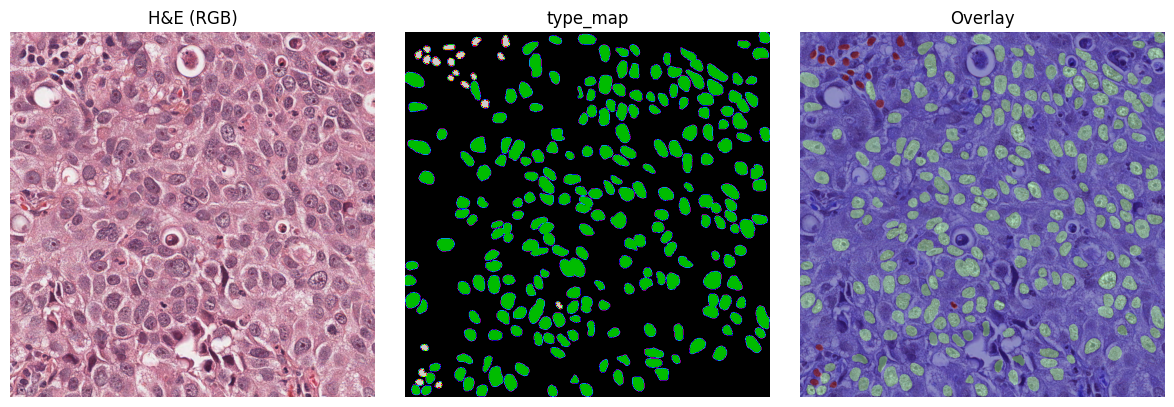

In [3]:
import numpy as np
from skimage import draw
from xml.dom import minidom
import cv2
import matplotlib.pyplot as plt
from openslide import OpenSlide

def parse_xml_to_maps(xml_path, image_shape, class_map, min_area=MIN_POLY_AREA):
    """
    Convert XML polygon annotations into instance and type maps.
    Returns (inst_map, type_map)
    """
    h, w = image_shape[:2]
    inst_map = np.zeros((h, w), dtype=np.int32)
    type_map = np.zeros((h, w), dtype=np.int32)
    inst_id = 1

    xmldoc = minidom.parse(str(xml_path))
    annotations = xmldoc.getElementsByTagName("Annotation")

    for ann in annotations:
        # find label name
        ann_label = None
        for attr in ann.getElementsByTagName("Attribute"):
            if attr.hasAttribute("Name"):
                ann_label = attr.getAttribute("Name").strip().lower()
                break
        if not ann_label:
            continue

        # map to numeric ID (skip unknowns)
        class_id = None
        for k, v in class_map.items():
            if v == ann_label:
                class_id = int(k)
                break
        if class_id is None:
            continue

        for reg in ann.getElementsByTagName("Region"):
            vertices = reg.getElementsByTagName("Vertex")
            if len(vertices) < 3:
                continue

            poly = np.array([(float(v.getAttribute("X")), float(v.getAttribute("Y")))
                             for v in vertices], dtype=np.float32)

            rr, cc = draw.polygon(poly[:, 1], poly[:, 0], (h, w))
            if len(rr) < min_area:
                continue  # skip tiny polygons

            inst_map[rr, cc] = inst_id
            type_map[rr, cc] = class_id
            inst_id += 1

    return inst_map, type_map


# --- Test on one sample ---
sample_row = pairs_df.iloc[0]
svs_path = sample_row["svs_path"]
xml_path = sample_row["xml_path"]

# open the slide and read RGB image
with OpenSlide(str(svs_path)) as slide:
    img = np.array(slide.read_region((0, 0), 0, slide.level_dimensions[0]))[:, :, :3]

inst_map, type_map = parse_xml_to_maps(xml_path, img.shape, class_map, min_area=MIN_POLY_AREA)

print("✅ Parsed:", svs_path.name)
print(" - Image shape:", img.shape)
print(" - Unique instances:", inst_map.max())
print(" - Classes in type_map:", np.unique(type_map))

# --- Quick overlay visualization ---
overlay = cv2.addWeighted(
    img, 0.6,
    cv2.applyColorMap((type_map.astype(np.float32) / type_map.max(initial=1) * 255).astype(np.uint8),
                      cv2.COLORMAP_JET),
    0.4, 0,
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("H&E (RGB)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(type_map, cmap="nipy_spectral")
plt.title("type_map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

<a id="step4"></a>
## Step 4 — Generate and save instance/type maps for all slides

In [4]:
from tqdm import tqdm
import numpy as np
import json
import pandas as pd
import os
from openslide import OpenSlide

# === Paths ===
OUTPUT_ROOT = OUT_ROOT / "whole_slide"
(OUTPUT_ROOT / "inst_maps").mkdir(parents=True, exist_ok=True)
(OUTPUT_ROOT / "type_maps").mkdir(parents=True, exist_ok=True)

# --- Load class map from _meta folder
with open(OUT_ROOT / "_meta" / "class_map.json", "r") as f:
    class_map = json.load(f)
print(f"Loaded class_map: {class_map}")

summary_records = []

# --- Iterate through slides
for _, row in tqdm(pairs_df.iterrows(), total=len(pairs_df), desc="Processing slides"):
    svs_path = row["svs_path"]
    xml_path = row["xml_path"]
    base = svs_path.stem

    try:
        with OpenSlide(str(svs_path)) as slide:
            w, h = slide.level_dimensions[0]
            rgb = np.array(slide.read_region((0, 0), 0, (w, h)))[:, :, :3]

        inst_map, type_map = parse_xml_to_maps(
            xml_path, rgb.shape, class_map, min_area=MIN_POLY_AREA
        )

        np.save(OUTPUT_ROOT / "inst_maps" / f"{base}_inst.npy", inst_map)
        np.save(OUTPUT_ROOT / "type_maps" / f"{base}_type.npy", type_map)

        summary_records.append({
            "slide": base,
            "instances": int(inst_map.max()),
            "classes_present": list(np.unique(type_map)),
            "height": h,
            "width": w,
        })

    except Exception as e:
        print(f"⚠️ Error processing {base}: {e}")

# --- Save summary
summary_df = pd.DataFrame(summary_records)
summary_csv = OUT_ROOT / "_meta" / "map_summary.csv"
summary_df.to_csv(summary_csv, index=False)

print(f"Saved summary → {summary_csv}")
display(summary_df.describe())


Loaded class_map: {'0': 'background', '1': 'epithelial', '2': 'lymphocyte', '3': 'macrophage', '4': 'neutrophil'}


Processing slides:   0%|          | 0/209 [00:00<?, ?it/s]

Processing slides: 100%|██████████| 209/209 [01:36<00:00,  2.17it/s]

Saved summary → /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20_2/_meta/map_summary.csv


,instances,height,width
count,209.000000,209.000000,209.000000
mean,150.258373,563.947368,628.320574
std,175.264910,371.355640,409.953512
min,2.000000,81.000000,74.000000
25%,10.000000,273.000000,311.000000
50%,58.000000,500.000000,523.000000
75%,269.000000,788.000000,859.000000
max,772.000000,1956.000000,2162.000000
